In [83]:
from numpy.linalg import inv
from scipy import misc

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import sklearn.preprocessing

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score


# load dataframe

In [3]:
# Shape files truncate column names.  This dictionary is used to restore the whole names.

col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

# Update path to the new shapefile I sent.

sl_df = gpd.read_file('flint_sl_materials/flint_sl_materials.shx')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

# Drop columns that aren't used by the classifier

drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry']

data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled data
data = data[~pd.isnull(data.dangerous)].reset_index()

data

,index,pid,Property Zip Code,Owner Type,Owner State,Homestead,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,...,B_aggregate_income,B_speak_spanish,B_speak_only_english,B_no_english,B_hispanic_household,B_imputed_rent,B_imputed_value,sl_private_type,sl_public_type,dangerous
0,38,4012482018,48503.0,Private,MI,Yes,100.0,18400,932,0,...,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1
1,47,4013226009,48503.0,Private,MI,Yes,100.0,11800,420,0,...,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1
2,53,4012476011,48503.0,Private,FL,No,0.0,0,602,0,...,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1
3,59,4012481022,48503.0,Private,MI,Yes,50.0,4550,781,0,...,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1
4,70,4013226025,48503.0,Private,MI,Yes,100.0,12800,510,0,...,6293700.0,19,805,0,3.0,160.0,0.0,COPPER,LEAD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26858,55806,4002378026,48504.0,Private,MI,Yes,100.0,19100,4291,0,...,NaN,0,649,0,9.0,74.0,244.0,GALVANIZED,LEAD,1
26859,55808,4002459029,48504.0,Private,MI,Yes,100.0,20900,2557,0,...,NaN,0,649,0,9.0,74.0,244.0,COPPER,LEAD,1
26860,55809,4002378013,48504.0,Private,MI,Yes,100.0,0,2651,717,...,NaN,0,649,0,9.0,74.0,244.0,GALVANIZED,LEAD,1
26861,55810,4002459031,48504.0,Private,MI,Yes,100.0,11200,1267,0,...,NaN,0,649,0,9.0,74.0,244.0,GALVANIZED,LEAD,1


# prepare train and test data

In [80]:
continuous_features = ['Latitude', 'Longitude']
discrete_features = ['PRECINCT']
target = ['dangerous']

training_data = data[continuous_features + discrete_features + target]
# for now we just ignore missingness because for our toy features, only 6 rows dropped
training_data = training_data.dropna()
print('Number of rows dropped due to missingness:', data.shape[0] - training_data.shape[0])

training_data.head()

Number of rows dropped due to missingness: 6


,Latitude,Longitude,PRECINCT,dangerous
0,43.019000,-83.696946,32,1
1,43.017650,-83.697217,40,1
2,43.020783,-83.697495,32,1
3,43.017543,-83.698229,40,1
4,43.013583,-83.695357,40,1


In [65]:
def get_train_test(training_data, n_data, random_state):
    
    sample = training_data.sample(n=n_data, random_state=random_state)

    Xdata = sample[continuous_features + discrete_features]
    Ydata = sample[target]

    # Groups for spatial cross validation
    groups = Xdata['PRECINCT']
    Xdata = Xdata.drop('PRECINCT', axis=1)

    # Group Shuffle Split example.  train_test_split could go here, but we like spatial cross validation 
    # better than a uniform random sample.
    train_idx, test_idx = list(GroupShuffleSplit(n_splits=1, train_size=.75, random_state=297).split(Xdata, Ydata, groups))[0]

    Xtrain = Xdata.iloc[train_idx].values
    Xtest = Xdata.iloc[test_idx].values
    Ytrain = Ydata.iloc[train_idx.tolist()].values.flatten().astype(int)
    Ytest = Ydata.iloc[test_idx.tolist()].values.flatten().astype(int)
    
    return Xtrain, Xtest, Ytrain, Ytest

# train spatial model

In [93]:
def get_trained_model(X, y, kernel):
    #isotropic kernel
    #kernel = 1.0 * RBF([1.0])
    gpc_rbf_anisotropic = 
    
    return GaussianProcessClassifier(kernel=kernel).fit(X,y)

# create a mesh to plot in

In [103]:
def plot_model(ax, model, X, y, title):
    
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - .01, X[:, 0].max() + .01
    y_min, y_max = X[:, 1].min() - .01, X[:, 1].max() + .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # predict on the mesh
    x1v, x2v = np.meshgrid(np.linspace(x_min, x_max,100), np.linspace(y_min, y_max,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]
    ygrid = model.predict(xgrid).reshape(x1v.shape)
    ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)

    ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto')

    dangerous_indices = [i for i in range(len(y)) if y[i]==1]
    safe_indices = [i for i in range(len(y)) if y[i]==0]

    ax.scatter(X[dangerous_indices,0], X[dangerous_indices,1], marker= 'x', s=200)
    ax.scatter(X[safe_indices,0], X[safe_indices,1], marker= 'o', s=200, alpha=.1)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title + '\n' + f"log marginal likelihood={model.log_marginal_likelihood(model.kernel_.theta)}")

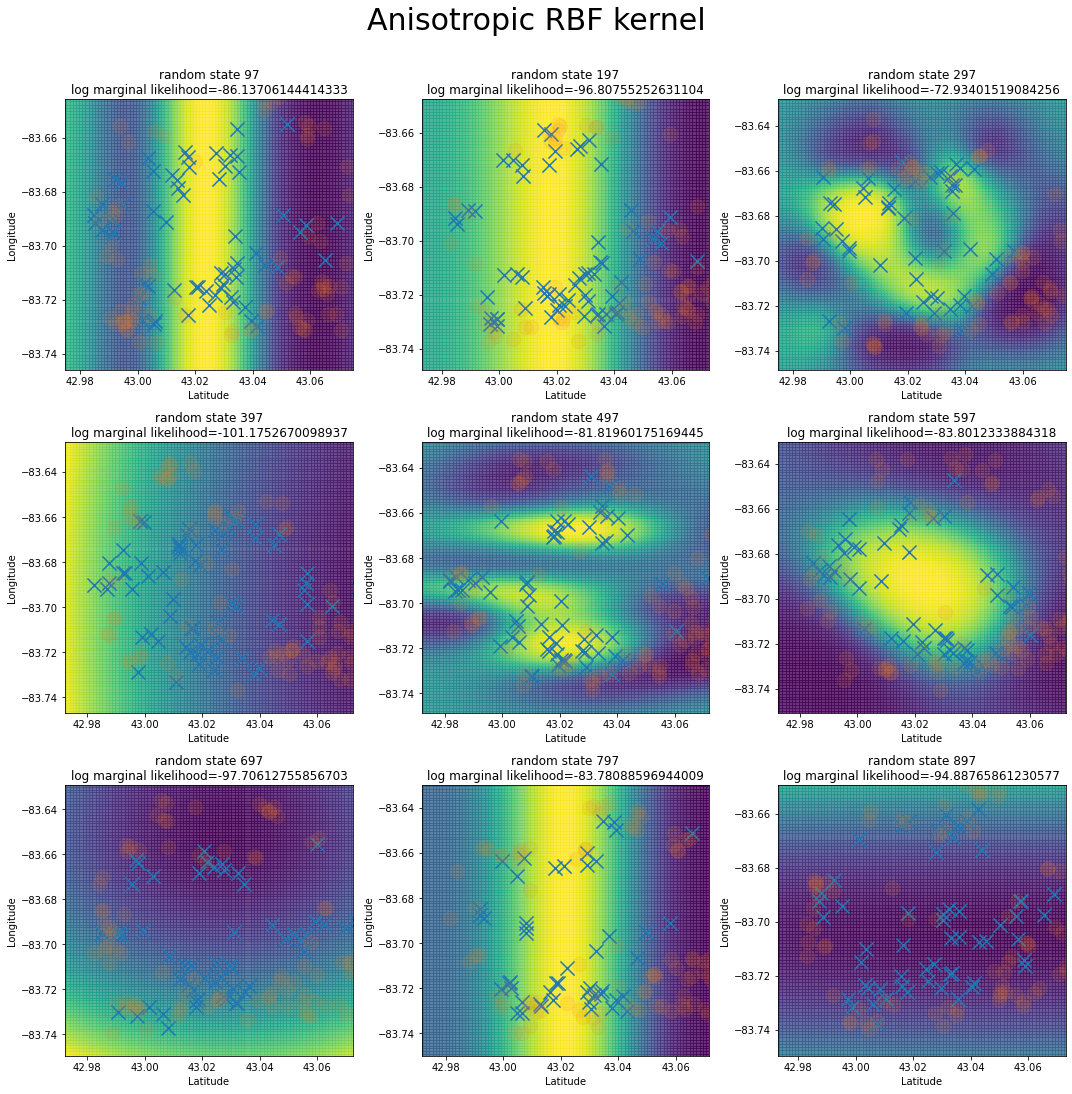

In [107]:
anisotropic_rbf_kernel = 1.0 * RBF([1.0, 1.0])

def ensemble_plot(nrows=2, ncols=2, kernel=anisotropic_rbf_kernel, suptitle='Anisotropic RBF kernel'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

    random_states = [97+i*100 for i in range(nrows*ncols)]
    for i, r in enumerate(random_states):
        ax = axes[i//ncols, i%ncols]
        x_train, x_test, y_train, y_test = get_train_test(training_data, 200, r)
        model = get_trained_model(x_train, y_train, kernel)
        plot_model(ax, model, x_train, y_train, title = f'random state {r}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()
    
ensemble_plot(nrows=3,ncols=3)

# cross validation to try different GP kernels

In [87]:
x_train, x_test, y_train, y_test = get_train_test(training_data, 300, 297)


model = GaussianProcessClassifier()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train, y_train)

In [92]:
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(" mean test accuracy %.3f with: %r" % (mean, param))

>0.789 with: {'kernel': 1**2 * RBF(length_scale=1)}
>0.625 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
>0.797 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
>0.795 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.625 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


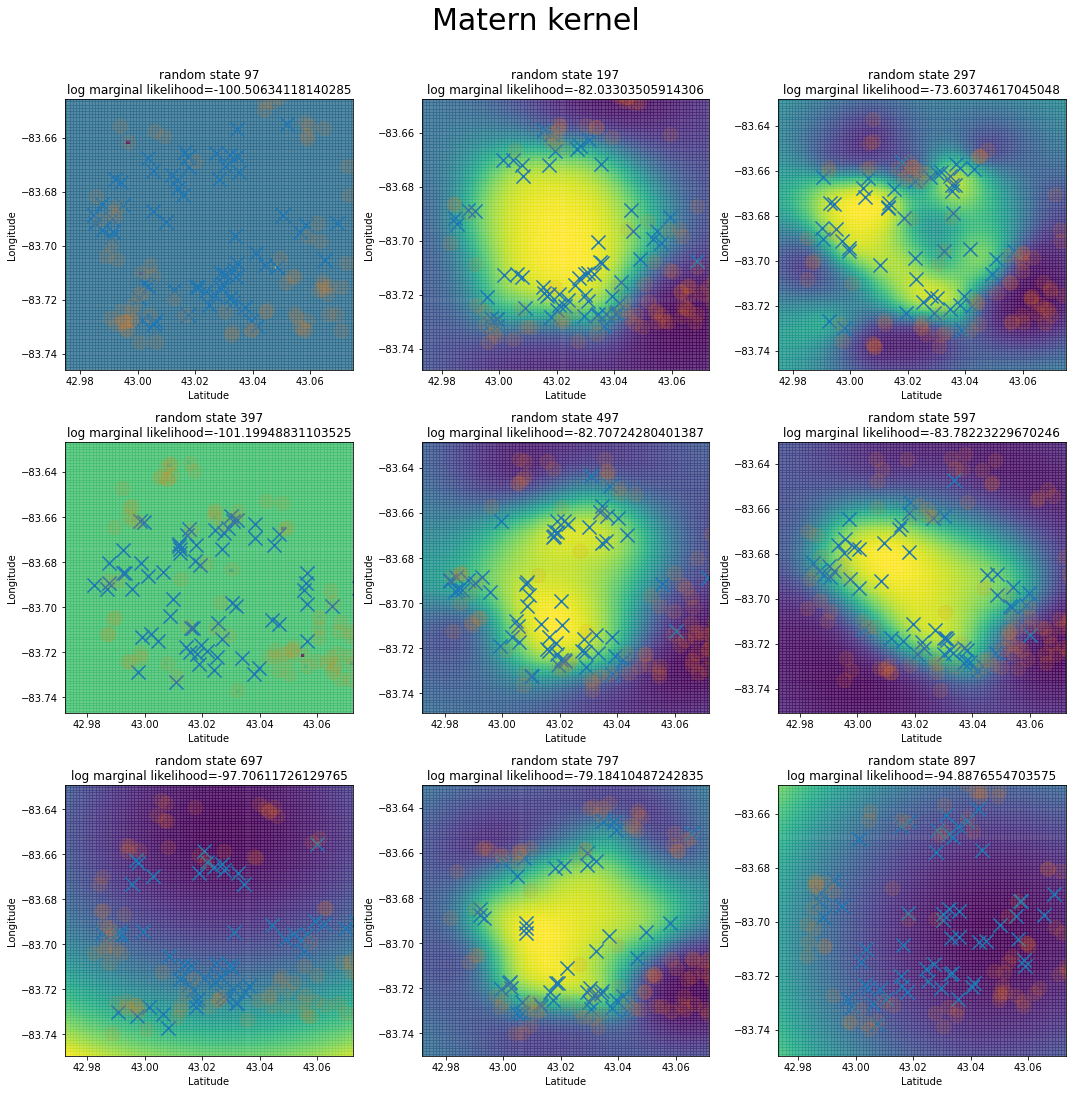

In [108]:
ensemble_plot(nrows=3, ncols=3, kernel = 1.0*Matern(length_scale=1,nu=1.5), suptitle='Matern kernel')